In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sns
from tqdm import tqdm
import scipy
import pandas as pd
import datetime

In [3]:
iris = datasets.load_iris()
X = iris.data[:, :2]
y = (iris.target != 0) * 1

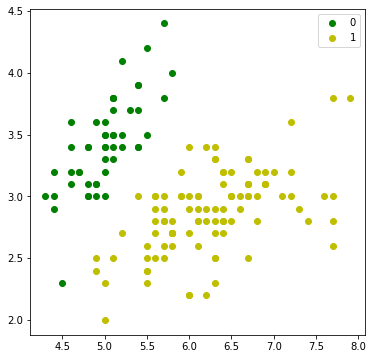

In [49]:
plt.figure(figsize=(6, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='g', label='0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='y', label='1')
plt.legend();

In [381]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.special import softmax
from scipy.optimize import minimize, minimize_scalar
import scipy.linalg as lg

class LogisticRegression():
    def __init__(self,x,y,l1=0.01):
        self.scaler = StandardScaler()
        self.scaler.fit(x)
        
        x = self.scaler.transform(x)
        
        self.intercept = np.ones((x.shape[0], 1))  
        self.x = np.concatenate((self.intercept, x), axis=1)
        
        self.y = y
        onehot_encoder = OneHotEncoder(sparse=False)
        self.y_onehot = onehot_encoder.fit_transform(self.y.reshape(-1,1))
        
        self.weight = np.zeros((self.x.shape[1], self.y_onehot.shape[1]), dtype=np.float64)
        
        self.l1 = l1
        
    #Sigmoid method
    def sigmoid(self, x, weight):
        z = x @ weight
        return 1 / (1 + np.exp(-z))
    
    #method to calculate the Loss
    def loss(self, W):
        N,m = self.x.shape
        Z = -self.x @ W
#         return np.mean( self.x @ W @ self.y_onehot.T + np.log( np.sum( np.exp( Z ) ) ) ) 
    
        return 1/N * ( np.trace( self.x @ W @ self.y_onehot.T ) + np.sum(np.log(np.sum(np.exp(Z)))) ) + self.l1*lg.norm(W)**2
    
    def __softmax(self, z):
        return softmax(z, axis)
    
    #Method for calculating the gradients
    def gradient_descent(self, maxiter, eta=0.01, tol=1e-7):
        W = self.weight
        loss= []
        i = 0
        
        while i <= maxiter and np.any(self.__gradient(W) > tol):
            W -= eta * self.__gradient(W)
            loss.append(self.loss(W))
            i+=1
        
        plt.plot(loss)
        plt.title("Loss")
        self.weight = W
        return W
    
    def __gradient(self,W):
        Z = -self.x @ W
        P = softmax(Z, axis=1)
        n = self.x.shape[0]
        return 1/n * (self.x.T @ ( self.y_onehot - P ) ) + 2*self.l1*W
    
    def fit(self, maxiter):
        def __f(w):
            W = w.reshape(self.weight.shape)
            return self.loss(W)
        
        def __df(w):
            W = w.reshape(self.weight.shape)
            return self.__gradient(W)
        
        opt_w = self.gradient_descent(maxiter)
        self.weight = opt_w
        accu = np.sum(np.argmax(softmax(self.x @ self.weight, axis = 1), axis = 1) == self.y) / len(self.y)
        print(f"fitted successfully to data with accuracy {accu}")
    
    #Method to predict the class label.
    def predict(self, x_new):
        x_new = self.scaler.transform(x_new)
        intercept = np.ones((x_new.shape[0], 1))
        
        x_new = np.concatenate((intercept, x_new), axis=1)
        
        Z = - x_new @ self.weight
        P = softmax(Z, axis=1)
        return np.argmax(P, axis=1)
    
    def predict_proba(self, x_new):
        x_new = np.concatenate((self.intercept, x_new), axis=1)
        
        Z = - x_new @ self.weight
        P = softmax(Z, axis=1)
        return P
    
    def accuracy(self, X, y):
        pred = self.predict(X)
        
        return np.sum( pred == y ) / len(y)

fitted successfully to data with accuracy 0.0
Accuracy: 0.9326599326599326


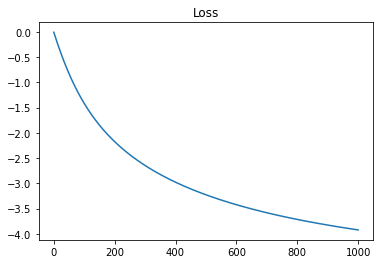

In [382]:
from sklearn.datasets import load_breast_cancer,load_iris,load_digits

from sklearn.model_selection import train_test_split

#Loading the data
data = load_digits()


#Preparing the data
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

 
#creating the class Object
regressor = LogisticRegression(X_train,y_train)
 

regressor.fit(maxiter=1000)

print("Accuracy:",regressor.accuracy(X_test,y_test))
# print('accuracy -> {}'.format(sum(y_pred == y) / y.shape[0]))

In [419]:
class Clogit():
    def __init__(self,x,y,choices,groups,l1=0.01):
        self.scaler = StandardScaler()
        self.scaler.fit(x)
        
        self.groups = groups
        self.R = len(groups)
        self.unique_choices, self.S = np.unique(choices, return_counts=True)
        self.n_choices = len(self.unique_choices)
        
        x = self.scaler.transform(x)
        
        self.intercept = np.ones((x.shape[0], 1))  
        self.x = np.concatenate((self.intercept, x), axis=1)
        
        self.y = y
        onehot_encoder = OneHotEncoder(sparse=False)
        self.y_onehot = onehot_encoder.fit_transform(self.y.reshape(-1,1))
        
        self.weight = np.zeros((self.x.shape[1], self.y_onehot.shape[1]), dtype=np.float64)
        
        self.l1 = l1

    def likelyhood(self, W):
        C = np.sum( np.log( np.factorial(self.R) ) - np.sum( np.log( np.factorial(self.S) ) ) )
        
        L = C + np.sum( np.sum( self.S @ self.x )* W - self.R * np.log(np.sum(np.exp(self.x @ W))) )
        return L + self.l1*lg.norm(W)**2
    
    def l_gradient(self, W):
        print(self.x.shape, W.shape)
        return np.sum( np.sum( self.S - self.R*softmax(self.x @ W, axis=1) ) @ self.x ) + 2*self.l1*W

    #Method for calculating the gradients
    def gradient_descent(self, maxiter, eta=0.01, tol=1e-7):
        W = self.weight
        loss= []
        i = 0
        
        while i <= maxiter and np.any(self.l_gradient(W) > tol):
            W -= eta * self.l_gradient(W)
            loss.append(self.loss(W))
            i+=1
        
        plt.plot(loss)
        plt.title("Loss")
        self.weight = W
        return W

    def fit(self, maxiter):
        opt_w = self.gradient_descent(maxiter)
        self.weight = opt_w
        accu = np.sum(np.argmax(softmax(self.x @ self.weight, axis = 1), axis = 1) == self.y) / len(self.y)
        print(f"fitted successfully to data with accuracy {accu}")
    
    #Method to predict the class label.
    def predict(self, x_new):
        x_new = self.scaler.transform(x_new)
        intercept = np.ones((x_new.shape[0], 1))
        
        x_new = np.concatenate((intercept, x_new), axis=1)
        
        Z = - x_new @ self.weight
        P = softmax(Z, axis=1)
        return np.argmax(P, axis=1)
    
    def predict_proba(self, x_new):
        x_new = np.concatenate((self.intercept, x_new), axis=1)
        
        Z = - x_new @ self.weight
        P = softmax(Z, axis=1)
        return P
    
    def accuracy(self, X, y):
        pred = self.predict(X)
        
        return np.sum( pred == y ) / len(y)

In [48]:
t = pd.read_csv("https://raw.githubusercontent.com/arteagac/xlogit/master/examples/data/car100_long.csv")

In [53]:
t.head(20)

,person_id,choice_id,alt,choice,price,opcost,range,ev,gas,hybrid,hiperf,medhiperf
0,1,1,1,0,46763,47.43,0.0,0,0,1,0,0
1,1,1,2,1,57209,27.43,1.3,1,0,0,1,1
2,1,1,3,0,87960,32.41,1.2,1,0,0,0,1
3,1,2,1,1,33768,4.89,1.3,1,0,0,1,1
4,1,2,2,0,90336,30.19,0.0,0,0,1,0,1
5,1,2,3,0,57099,27.16,1.8,1,0,0,1,1
6,1,3,1,1,45534,10.72,1.2,1,0,0,0,0
7,1,3,2,0,21825,15.53,0.0,0,0,1,1,1
8,1,3,3,0,34031,60.62,0.0,0,1,0,0,0
9,1,4,1,0,8639,22.16,0.0,0,1,0,0,1


In [172]:
df = pd.read_csv("data/data_small.csv", index_col=0)
df.head()

C:\Users\raves\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (41,42) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,num,nom,numCoursePMU,classement,id,date,meanReduction,medianReduction,maxReduction,minReduction,...,txReussiteTrainer_z,nbCourseTandem_z,nbVictoiresTandem_z,nb2emeTandem_z,nb3emeTandem_z,txReussiteTandem_z,nbVictoiresDriver_z,nb2emeDriver_z,nb3emeDriver_z,txReussiteDriver_z
105948,1,HERMINE CAPTAIN,R1C1,7,2021010275001,2021-01-02,777.300000,778.5,794,759,...,-0.391964,-1.028555,-0.985144,-0.809383,-0.930481,-1.828190,0.687718,1.085956,0.790749,0.265162
105949,2,HAYASTAN DE ROSAN,R1C1,8,2021010275001,2021-01-02,770.777778,770.0,798,742,...,-0.580687,0.496233,-0.273651,0.045528,0.014539,-0.418315,-0.916409,-0.904283,-0.902384,-1.602023
105950,3,HOCEANARA,R1C1,6,2021010275001,2021-01-02,766.625000,759.5,795,744,...,-1.146856,-1.009007,-0.985144,-0.743620,-0.930481,-0.485452,0.035373,0.250056,0.289720,-0.309356
105951,4,HARMONIE MERITE,R1C1,9,2021010275001,2021-01-02,774.625000,776.5,794,738,...,-0.769410,-0.217290,-0.403013,-0.151759,0.014539,0.387328,1.008543,0.953274,1.015349,0.265162
105952,5,HERMINE DE RHEVE,R1C1,3,2021010275001,2021-01-02,757.750000,755.5,782,738,...,0.362929,-0.197741,0.179117,0.308577,0.109041,1.662930,2.259762,1.935125,2.138345,1.845088


In [180]:
feat = df.loc[:]
feat["txReussiteCouple_z"] = feat["txReussiteCouple_z"]

feat["lifepercwin"] = feat["nombreVictoires"] / feat["nombreCourses"]
feat["winPrace"] = feat["gainsParticipant_gainsAnneeEnCours"] / feat["nombreCourses"]
feat["newDist"] = abs(feat["last_race_dist"] - feat["dist"]) > 150

feat.fillna(0,inplace=True)

feat["win"] = feat["classement"] == 1

feat["available"] = 1

feat = feat.set_index(["id", df.groupby("id").cumcount()])
index = pd.MultiIndex.from_product(feat.index.levels, names=feat.index.names)
feat = feat.reindex(index, fill_value=0).reset_index(level=1, drop=True).reset_index()

nindex = 1772 * list(range(1,19))

feat = feat.assign(num=nindex)

feat["classement"] = feat["classement"].replace(0,10)
feat["win"] = feat["win"].replace(False,0)
feat["win"] = feat["win"].replace(True,1)

feat["trainerIsDriver"] = feat["trainerIsDriver"].astype(int)
feat["newDist"] = feat["newDist"].astype(int)

feat = feat.groupby("id").filter(lambda x: x.win.sum() == 1)
feat["chid"] = feat["id"].astype(str) + "_1"

In [181]:
n_explo = 2

nfeat = feat.iloc[:18*len(feat.groupby("id"))//2].copy()

train = nfeat.copy()
print(len(train.groupby("chid")))
for i in range(2,n_explo+2):
    cfeat = nfeat.copy()

    cfeat["win"] = 0
    cfeat.loc[cfeat["classement"].isin( list(range(1,i)) ), ~cfeat.columns.isin(["id","num"])] = 0
    cfeat.loc[cfeat["classement"] == i, "win"] = 1
    cfeat["chid"] = cfeat["id"].astype(str) + f"_{i}"
    
    train = pd.concat([train, cfeat])
    print(len(train.groupby("chid")))
    
train = train.sort_values(by=["id", "chid", "num"])

885
1770
2655


In [182]:
n_course = len(nfeat.groupby("id"))

# train = nfeat.loc[:].iloc[:18 * ( 2 * len(nfeat.groupby("chid"))//3)]
train = train.groupby("chid").filter(lambda x: x.win.sum() == 1)
test = feat.loc[:].iloc[18 * len(feat.groupby("id")) // 2:]

In [185]:
print(len(train.groupby("chid")))

2649


In [232]:
from collections import OrderedDict    # For recording the model specification 

import pandas as pd                    # For file input/output
import numpy as np                     # For vectorized math operations
import statsmodels.tools.numdiff as numdiff       # For numeric hessian
import scipy.linalg                    # For matrix inversion

import pylogit as pl                   # For choice model estimation
from pylogit import nested_logit as nl # For nested logit convenience funcs
from xlogit import MixedLogit
import pickle

In [234]:
pickle.dump(model, open("exploded.pkl", "wb"))

In [187]:
model = MixedLogit()
model.check_if_gpu_available()

1 GPU device(s) available. xlogit will use GPU processing


True

In [248]:
features_back = ["fer","nb2emeTandem_z","nb2emeCouple_z","newDist","timeBehindBestInRace_z","timeBehindBestMeanInRace_z","recordAbs","nbDiscalifieMusic","nbVictoireMusic","nbPlaceMusic","nombrePlacesSecond","nombrePlacesTroisieme_z","gainsParticipant_gainsAnneePrecedente_z","gainsParticipant_gainsVictoires_z","txReussiteTandem_z","lifepercwin","gainsParticipant_gainsAnneeEnCours_z", "txReussiteCouple_z", "nbCourseCouple_z","nbVictoiresCouple_z", "txReussiteTrainer_z", "timeSinceRecord_z", "nombreVictoires_z"]
features = ["fer","nbDiscalifieMusic","timeBehindBestInRace_z","timeBehindBestMeanInRace_z","nombrePlacesSecond","nombrePlacesTroisieme_z", "txReussiteCouple_z", "nbCourseCouple_z","nbVictoiresCouple_z", "txReussiteTrainer_z", "timeSinceRecord_z", "nombreVictoires_z"]


# randvars = {name:"n" for name in features}
randvars={"nbDiscalifieMusic":"n"}

In [249]:
model.fit(X = train[features], y = train["win"], varnames=features, ids=train["chid"], panels=train["id"], alts=train["num"], n_draws=500,maxiter=1000,mnl_init=True, randvars=randvars)
model.summary()

GPU processing enabled.
Optimization terminated successfully.
    Message: The gradients are close to zero
    Iterations: 7
    Function evaluations: 9
Estimation time= 1.1 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
fer                     0.3340683     0.0140294    23.8120229     1.95e-112 ***
nbDiscalifieMusic       0.0467809     0.0121652     3.8454625        0.0005 ***
timeBehindBestInRac     0.0259108     0.0254127     1.0195995         0.474    
timeBehindBestMeanI    -0.3010244     0.0261742   -11.5008015      7.31e-29 ***
nombrePlacesSecond      0.1066475     0.0096867    11.0096764      1.43e-26 ***
nombrePlacesTroisie    -0.0582533     0.0221424    -2.6308528        0.0251 *  
txReussiteCouple_z      0.1800193     0.0233555     7.7078065      1.38e-13 ***
nbCourseCouple_z       -0.1318

In [250]:
choice, proba = model.predict(X=test[features], varnames=features, ids=test["id"], alts=test["num"],return_proba=True)

GPU processing enabled.


In [251]:
winners_odd = test.loc[test["win"] == 1]["dernierRapportDirect_rapport"].to_numpy()
winners = test.loc[test["win"] == 1]["num"].to_numpy()

odds = test["dernierRapportDirect_rapport"].to_numpy().reshape(-1,18)

def kelly(p,b):
    return p - (1-p)/b

def expe(p,b):
    e = p*b - (1-p)
    m_e = np.argmax( p*b - (1-p) )
    return m_e, e[m_e]

In [252]:
win = 0
tot = 0
for i in range(len(choice)):
    if winners[i] == choice[i]:
        win+=1
    tot+=1
print(f"Win%: {win/tot}, nbet: {tot}")

Win%: 0.1943502824858757, nbet: 885


                0
mean    43.016667
max     99.000000
min      3.500000
median  38.000000
Win%: 0.07582938388625593, nbet: 633


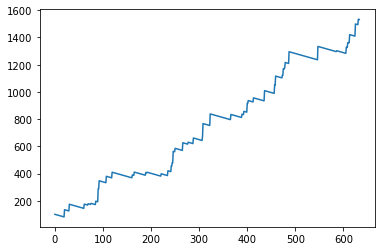

In [259]:
from statsmodels.stats.descriptivestats import describe
win = 0
tot = 0
odds_winned = []

cap = 100
evo = [cap]


for i in range(len(choice)):
    cheval,Er = expe(proba[i], odds[i])
    if odds[i][cheval] > 0 and odds[i][cheval] < 100 and Er >  1:
        
        wagger = kelly(proba[i][cheval],odds[i][cheval]) * cap
        if winners[i] == cheval:
            win += 1
#             print(f"Win le {winners[i]}|{cheval} a gagné  avec une cote de {odds[i][cheval]}")
            cap += odds[i][cheval]
            odds_winned.append(odds[i][cheval])
        cap -= 1
        evo.append(cap)
        tot+=1
print(describe(odds_winned, stats=["max", "min", "mean", "median"]))
print(f"Win%: {win/tot}, nbet: {tot}")
plt.plot(evo)

In [38]:
# Create the model's specification dictionary and variable names dictionary
# NOTE: - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         or lists of lists. Within a list, or within the inner-most
#         list should be the alternative ID's of the alternative whose
#         utility specification the explanatory variable is entering.




# features_bu = ["available","trainerIsDriver","txReussiteDriver_z","fer","nbArrivé_z","nb3emeTandem_z","nb3emeDriver_z","nb3emeCouple_z","nb2emeTandem_z","nb2emeCouple_z","newDist","timeBehindBestInRace_z","timeBehindBestMeanInRace_z","recordAbs","nbDiscalifieMusic","nbVictoireMusic","nbPlaceMusic","nombrePlacesSecond","nombrePlacesTroisieme_z","gainsParticipant_gainsAnneePrecedente_z","gainsParticipant_gainsVictoires_z","txReussiteTandem_z","winPrace","lifepercwin","gainsParticipant_gainsAnneeEnCours_z", "txReussiteCouple_z", "nbCourseCouple_z","nbVictoiresCouple_z", "txReussiteTrainer_z", "timeSinceRecord_z", "nombreVictoires_z"]
features = ["fer","nb2emeTandem_z","nb2emeCouple_z","newDist","timeBehindBestInRace_z","timeBehindBestMeanInRace_z","recordAbs","nbDiscalifieMusic","nbVictoireMusic","nbPlaceMusic","nombrePlacesSecond","nombrePlacesTroisieme_z","gainsParticipant_gainsAnneePrecedente_z","gainsParticipant_gainsVictoires_z","txReussiteTandem_z","lifepercwin","gainsParticipant_gainsAnneeEnCours_z", "txReussiteCouple_z", "nbCourseCouple_z","nbVictoiresCouple_z", "txReussiteTrainer_z", "timeSinceRecord_z", "nombreVictoires_z"]

example_specification = OrderedDict()
example_names = OrderedDict()

for col in features:
    example_specification[col] = [list(range(1,19))]
    example_names[col] = [col]

In [45]:
# Provide the module with the needed input arguments to create
# an instance of the MNL model class


example_mixed = pl.create_choice_model(data=train,
                                        alt_id_col="num",
                                        obs_id_col="id",
                                        choice_col="win",
                                        specification=example_specification,
                                        model_type="Mixed Logit",
                                        names=example_names,
                                        mixing_id_col="id",
                                        mixing_vars=features)

# Create the initial values for estimation.
# Note that we need one value for each beta
# coefficient and for each of the standard deviations
# that will now be estimated.

example_mixed.fit_mle(init_vals=np.zeros(2 * len(features)),
                      num_draws=500)

example_mixed.get_statsmodels_summary()

Log-likelihood at zero: -5,130.4099
Initial Log-likelihood: -5,130.4099


C:\Users\raves\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:548: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


KeyboardInterrupt: 

In [11]:
preds = example_mixed.predict(test, num_draws=100).reshape(-1,18)
preds_course = np.argmax(preds, axis=1) + 1
acu = sum(test.loc[test["win"] == 1]["num"] == preds_course) / len(preds_course)
print(acu)

0.2790960451977401


In [13]:
winners_odd = test.loc[test["win"] == 1]["dernierRapportDirect_rapport"].to_numpy()

In [71]:
winners_odd = test.loc[test["win"] == 1]["dernierRapportDirect_rapport"].to_numpy()

def kelly(p,b):
    return p - (1-p)/b

def expe(p,b):
    e = p*b - (1-p)
    m_e = np.argmax( p*b - (1-p) )
    return m_e, e[m_e]

In [106]:
winners = test.loc[test["win"] == 1]["num"].to_numpy()
odds = test["dernierRapportDirect_rapport"].to_numpy().reshape(-1,18)

sorted_preds = np.argsort(preds)

best_p = 0
best_er = 0

best_cap = 0



for p_tresh in np.linspace(0,0.2,40):
    for er_tresh in np.linspace(0,1.5,40):
        win = 0
        tot = 0
    #     odds_winned = []

        cap = 100
    #     evo = [cap]


        for i in range(len(preds)):
            preds1 = sorted_preds[i][-1]
            preds2 = sorted_preds[i][-2]
            cheval,Er = expe(preds[i], odds[i])
            if odds[i][cheval] > 0 and Er > er_tresh and preds[i][cheval] > p_tresh:
                wagger = kelly(preds[i][cheval],odds[i][cheval]) * cap
                if winners[i] == cheval + 1:
                    win += 1
                    cap += wagger * odds[i][cheval]
    #                 odds_winned.append(odds[i][cheval])
                cap -= wagger
    #             evo.append(cap)
                tot+=1

        if cap > best_cap:
            best_cap = cap
            best_p = p_tresh
            best_er = er_tresh
print(f"Best cap: {best_cap} for params: {best_p=}, {best_er=}")

Best cap: 460.79357800673836 for params: best_p=0.015384615384615385, best_er=0.9230769230769231


                 0
mean     21.361538
max     173.000000
min       4.400000
median    8.000000
Win%: 0.13829787234042554, nbet: 94


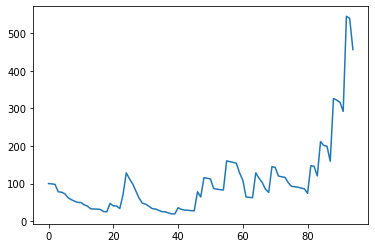

In [108]:
from statsmodels.stats.descriptivestats import describe
win = 0
tot = 0
odds_winned = []

cap = 100
evo = [cap]


winners_odd = test.loc[test["win"] == 1]["dernierRapportDirect_rapport"].to_numpy()

def kelly(p,b):
    return p - (1-p)/b

def expe(p,b):
    e = p*b - (1-p)
    m_e = np.argmax( p*b - (1-p) )
    return m_e, e[m_e]

for i in range(len(preds)):
    preds1 = sorted_preds[i][-1]
    preds2 = sorted_preds[i][-2]
    cheval,Er = expe(preds[i], odds[i])
    if odds[i][cheval] > 0 and Er > 0.92 and preds[i][cheval] > 0.015:
        wagger = kelly(preds[i][cheval],odds[i][cheval]) * cap
        if winners[i] == cheval + 1:
            win += 1
            cap += wagger * odds[i][cheval]
            odds_winned.append(odds[i][cheval])
        cap -= wagger
        evo.append(cap)
        tot+=1
print(describe(odds_winned, stats=["max", "min", "mean", "median"]))
print(f"Win%: {win/tot}, nbet: {tot}")
plt.plot(evo)

In [89]:
mean_odds = np.mean(odds_winned)
median_odds = np.median(odds_winned)
print(mean_odds, median_odds, np.max(odds_winned), np.min(odds_winned))

5.328688524590164 4.8 15.0 1.4


In [99]:
test

,id,num,nom,numCoursePMU,classement,date,meanReduction,medianReduction,maxReduction,minReduction,...,txReussiteTandem_z,nbVictoiresDriver_z,nb2emeDriver_z,nb3emeDriver_z,txReussiteDriver_z,lifepercwin,winPrace,newDist,win,available
15948,2021072250083,1,HIPPO DE BEAUM,R6C3,10,2021-07-22,783.571429,781.0,822,765,...,-1.681135,-0.714631,-0.735320,-0.873203,-2.227441,0.000000,19583.333333,0,0,1
15949,2021072250083,2,HACH DES CAPELLES,R6C3,8,2021-07-22,801.000000,802.0,805,794,...,-0.898975,-0.697110,-0.718105,-0.873203,-0.928100,0.100000,99700.000000,1,0,1
15950,2021072250083,3,HOCHE,R6C3,1,2021-07-22,777.000000,777.5,784,769,...,0.665343,1.475570,1.055025,0.948539,0.725606,0.000000,70000.000000,0,1,1
15951,2021072250083,4,HADOL DU CHATELET,R6C3,10,2021-07-22,783.142857,790.0,795,761,...,1.660819,0.249057,0.504149,1.164271,0.371240,0.066667,48866.666667,1,0,1
15952,2021072250083,5,HAUGAIN,R6C3,6,2021-07-22,781.500000,784.5,798,759,...,-0.970081,-0.714631,-0.735320,-0.801293,-1.046222,0.100000,116700.000000,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31891,2021123175009,14,HORCHATA,R1C9,7,2021-12-31,766.727273,765.0,807,733,...,1.153314,-0.046198,-0.047263,0.186222,-0.025928,0.142857,133761.904762,1,0,1
31892,2021123175009,15,HELIA DU GARABIN,R1C9,8,2021-12-31,769.500000,766.5,805,741,...,-0.314991,-0.847823,-0.962680,-1.116216,-0.440775,0.307692,210000.000000,1,0,1
31893,2021123175009,16,HELEN DES OUBEAUX,R1C9,4,2021-12-31,774.500000,766.5,811,750,...,-0.672146,0.620089,1.040624,0.560896,0.527201,0.000000,50875.000000,1,0,1
31894,2021123175009,17,0,0,10,0,0.000000,0.0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0


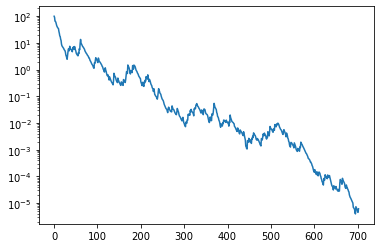

In [90]:
plt.plot(evo)
plt.yscale("log")

In [3]:
import pickle
example_mixed = pickle.load(open("mixedlogit1.pkl", "rb"))